<a href="https://colab.research.google.com/github/take2rohit/denoising_autoencoder/blob/master/22_cleaned_resnet_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ruphan/OrigamiDataset
# !git clone https://github.com/take2rohit/denoising_autoencoder.git 
# !cp -rf denoising_autoencoder/DAE_dataset_helper.py .
# !rm -rf denoising_autoencoder

Cloning into 'OrigamiDataset'...
remote: Enumerating objects: 46466, done.
remote: Total 46466 (delta 0), reused 0 (delta 0), pack-reused 46466
Receiving objects: 100% (46466/46466), 451.52 MiB | 20.70 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (30304/30304), done.


In [2]:
# get helper files and dataset
#importing the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import os
import json
from itertools import combinations
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# From custom helper
# from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
# from DAE_dataset_helper import ToTensor,Resize, Normalize,AddNoise,RandomBackground
# from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate

# Dataset Loading, Visualising and Architecture design 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np,os

class AddNoise(object):
    def __init__(self, mean, var, noise_typ = "gauss"):
        self.noise_typ = noise_typ
        self.mean = mean 
        self.var = var
    
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']

        if self.noise_typ == "gauss":
            row,col,ch= augmented.shape
            mean = self.mean
            var = self.var
            sigma = var**0.5
            gauss = np.random.normal(mean,sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy = noisy = np.clip(augmented + gauss, 0,1)

        if self.noise_typ == "s&p":
            row,col,ch = augmented.shape
            s_vs_p = self.mean
            amount = self.var
            out = np.copy(augmented)
            # Salt mode
            num_salt = np.ceil(amount * augmented.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt))
                    for i in augmented.shape]
            out[coords] = 255

            # Pepper mode
            num_pepper = np.ceil(amount* augmented.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper))
                    for i in augmented.shape]
            out[coords] = 0
            noisy = out
        
        return {'original': original,
                'augmented': noisy,
                'dof_vec' : sample['dof_vec']}    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        original = np.transpose(original, (2, 0, 1))
        augmented = np.transpose(augmented, (2, 0, 1))
        return {'original': torch.from_numpy(original).float(),
                'augmented': torch.from_numpy(augmented).float(),
                'dof_vec' : torch.from_numpy(sample['dof_vec']).float()}

class Resize(object):
    """ndarrays resize."""
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        original = cv2.resize(original, dsize=self.size, interpolation=cv2.INTER_CUBIC)
        original = np.expand_dims(original, axis=2)

        augmented = cv2.resize(augmented, dsize=self.size, interpolation=cv2.INTER_CUBIC)

        return {'original': original, 
                'augmented':augmented,
                'dof_vec' : sample['dof_vec'] }

class Normalize(object):
    
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        min_noisy,max_noisy = np.min(original),np.max(original)
        original = (original - min_noisy)/(max_noisy-min_noisy)
        
        min_noisy,max_noisy = np.min(augmented),np.max(augmented)
        augmented = (augmented - min_noisy)/(max_noisy-min_noisy)
        return {'original': original, 
                'augmented':augmented,
                'dof_vec' : sample['dof_vec'] }

In [8]:
class DataLoadResUnet(Dataset):

    def __init__(self, origami_dir, bg_dir, csv_dir, dataset_size=150,transform=None):
        self.bg_dir = bg_dir
        self.origami_dir = origami_dir
        self.transform = transform
        self.dataset_size=dataset_size
        self.dframe = pd.read_csv(csv_dir)
        
        self.orgami_list = [f for f in os.listdir(self.origami_dir) \
         if os.path.isfile(os.path.join(self.origami_dir, f))]
        
        self.dataset_size=len(self.orgami_list)

        self.bg_list = [f for f in os.listdir(self.bg_dir) \
         if os.path.isfile(os.path.join(self.bg_dir, f))]

    def merge(self,origami_loc, background_loc):
        origami = cv2.imread(origami_loc)
        origami_black_bg = origami.copy()
        background = cv2.imread(background_loc)
        background = cv2.resize(background, dsize=(origami.shape[0],origami.shape[1]),
                                interpolation=cv2.INTER_CUBIC)
        frame_threshold = cv2.inRange(cv2.cvtColor(origami, cv2.COLOR_BGR2HSV), 
                                      (50, 50, 50), (70, 255, 255))
        op_image = cv2.bitwise_and(origami_black_bg, origami_black_bg, mask=cv2.bitwise_not(frame_threshold))
        bg = cv2.bitwise_and(background, background, mask=frame_threshold)
        in_image = cv2.bitwise_or(op_image, bg)
        
        # op_image = cv2.cvtColor(op_image, cv2.COLOR_BGR2RGB)
        op_image = cv2.cvtColor(op_image, cv2.COLOR_BGR2GRAY)
        in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)
    
        return in_image, op_image
    
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):

        # idx_bg = idx 
        # idx_org = int((idx/len(self.bg_list))*len(self.orgami_list))    
        
        idx_org = idx
        idx_bg = np.random.randint(1,len(self.bg_list))-1
        
        greenScreen_origami_path = os.path.join(self.origami_dir,
                                self.orgami_list[idx_org])

        bg_img_path = os.path.join(self.bg_dir,
                                self.bg_list[idx_bg])
        
        # print(self.self.df[self.df['Name']==str(self.orgami_list[idx_org])])
        # print(self.orgami_list[idx][:-4])
        # dof_vec = self.df[self.df['Name']==str(self.orgami_list[idx_org])].values[0]

        dof_vec = self.dframe[self.dframe['Img_Name']==self.orgami_list[idx][:-4]].values[0]
        origami_merged, origami_black_bg = self.merge(greenScreen_origami_path,bg_img_path)
        
        sample = {'augmented': origami_merged, 
                  'original': origami_black_bg,
                  'dof_vec' : dof_vec[1:7].astype(float)}

        if self.transform:
            sample = self.transform(sample)

        return sample

Training dataset size: 28500        Testing dataset size: 1500
Input to network


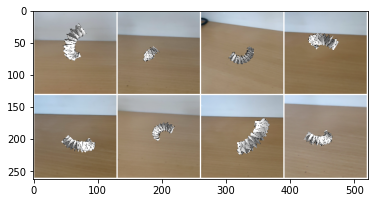

Output of network (To be verified with)


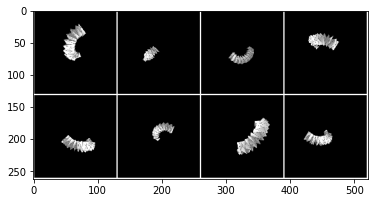

In [10]:
train_batch_size = 8
test_batch_size = 4
split_percent = 0.95

origami_dataset_dir = "/content/OrigamiDataset/Omega"
random_background_dir = '/content/OrigamiDataset/BackgroundImages'
csv_dir = '/content/OrigamiDataset/pose_data.csv'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)),Normalize()
                            ,ToTensor()])

origami = DataLoadResUnet(origami_dataset_dir,random_background_dir,
                                csv_dir, transform=trns)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=True,**kwargs)

print(f'Training dataset size: {len(train_dataset)} \
       Testing dataset size: {len(test_dataset)}')


iterator = iter(train_loader)
sample = iterator.next()

augmented,original, dof_vec = sample['augmented'],sample['original'], sample['dof_vec']

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

### Model File

In [11]:
#defining the resunet model in pytorch

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True)
    )

def root_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
    )

# Define the ResNetUNet architecture
class ResNetUNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()
        
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down11 = root_block(64, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down21 = root_block(128, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down31 = root_block(256, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down41 = root_block(512, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up31 = root_block(256, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up21 = root_block(128, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up11 = root_block(64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

        self.maxpool_lin = nn.MaxPool2d(4)
        self.linear1 = nn.Linear(8192,1024)
        self.linear2 = nn.Linear(1024, 6)
        # self.linear3 = nn.Linear(2048, 6)



    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.dconv_down11(conv1)
        x += conv1
        x = self.relu(x)
        x = self.maxpool(x)

        conv2 = self.dconv_down2(x)
        x = self.dconv_down21(conv2)
        x += conv2
        x = self.relu(x)
        x = self.maxpool(x)

        conv3 = self.dconv_down3(x)
        x = self.dconv_down31(conv3)
        x += conv3
        x = self.relu(x)
        x = self.maxpool(x)

        conv4 = self.dconv_down4(x)
        x = self.dconv_down41(conv4)
        x += conv4
        x = self.relu(x)
        
        ######### latent variable #########

        latent = self.maxpool_lin(x)
        flat = latent.reshape((int(latent.shape[0]),-1))

        y = self.linear1(flat)
        y = self.relu(y)
        y = self.linear2(y)
        y = self.relu(y)

        dof = y
 
        ####################

        deconv3 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        deconv3 = torch.cat([deconv3, conv3], dim=1)
        uconv3 = self.dconv_up3(deconv3)
        x = self.dconv_up31(uconv3)
        x += uconv3
        x = self.relu(x)

        deconv2 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        deconv2 = torch.cat([deconv2, conv2], dim=1)
        uconv2 = self.dconv_up2(deconv2)
        x = self.dconv_up21(uconv2)
        x += uconv2
        x = self.relu(x)

        deconv1 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        deconv1 = torch.cat([deconv1, conv1], dim=1)
        uconv1 = self.dconv_up1(deconv1)
        x = self.dconv_up11(uconv1)
        x += uconv1
        x = self.relu(x)

        out = self.conv_last(x)
        out = self.tanh(out)
        return out,dof

model = ResNetUNet()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'learnable parameters: {params}')

learnable parameters: 24007943


# Start Training



In [12]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [13]:
def train(model, device, train_loader, optimizer, loss_formula, epoch,log_interval=20):
    global store_train_loss
    model.train()
    # l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        reconst, dof_estimate = model(data)

        loss = loss_formula(reconst, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))
    
    store_train_loss.append([epoch,loss.item()])
    # scheduler.step()

def imshow_saver(data, reconst,save_img_name, images_show = 8):
    '''
    Construct a grid for both reconstruction and input image values
    Also save them with filename save_img_name
    '''
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    img = torchvision.utils.make_grid(data[:images_show,:], **kwargs)
    npimg = img.cpu().numpy()
    data_np = np.transpose(npimg, (1, 2, 0))

    img = torchvision.utils.make_grid(reconst[:images_show,:], **kwargs)
    npimg = (img.cpu().numpy() + 1)/2
    reconst_np = np.transpose(npimg, (1, 2, 0))

    cat = np.vstack((data_np,reconst_np))

    plt.imshow(cat)
    plt.imsave(save_img_name, cat)
    print(np.max(reconst_np), np.min(reconst_np))
    plt.show()

def test(model, device, test_loader,loss_formula,save_img=False,ep=None,save_folder=None):
    model.eval()
    global store_test_loss 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            reconst, dof_estimate = model(data)
            test_loss += loss_formula(reconst,target) # sum up batch loss
    test_loss /= max(1,c)
    
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    store_test_loss.append([ep,(test_loss).item()])
    if save_img:
        imshow_saver(data, reconst,os.path.join(save_folder,f'epoch_{ep}.png'),
                     images_show = data.shape[0])
        print('image saved')

def loss_plotter(store_train_loss, store_test_loss, epoch, location):
    store_train_loss= np.array(store_train_loss)
    store_test_loss= np.array(store_test_loss)
    plt.plot(store_train_loss[:,0], store_train_loss[:,1], label='Train Loss')
    plt.plot(store_test_loss[:,0], store_test_loss[:,1], label='Test Loss')
    plt.legend()
    plt.savefig(os.path.join(location,'plots',f'plot_{epoch}.png'))
    plt.show()

def google_drive_store(root, save_model_name, load_saved_model = True):
    '''
    Saves all model file, intermediate results and plots on drive location. 
    It will create folder as well. Make sure to mount drive before
    @param- saved_model_pth: save ur model with with this name 
            if already exsists, load these weights
    @param- load_saved_model: bool-Load saved model ?

    '''
    # root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab/gs_haptic3'
    # save_model_name = "gs_haptic3.pt"

    ### Create folders if not exists
    saved_model_pth = os.path.join(os.path.join(root,save_model_name))
    if not os.path.exists(root):
        os.mkdir(root)
        print(f'Folder created: {root}')

    if os.path.exists(saved_model_pth) and load_saved_model:
        model.load_state_dict(torch.load(saved_model_pth))
        print("MODEL loaded")

    if not os.path.exists(os.path.join(root,'plots')):
        os.mkdir(os.path.join(root,'plots'))


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Start Training Here

> The only variable u need to change is root. The code will handle foler creations

- Intermediate **plots** are saved in `root/plots/plot_{epoch}.png`
- **Models weights** are saved in `root/save_model_name.pt`
- **Intermediate reconstructions** are saved at `root`

Remeber to delete old plots and saved results to avoid confusions between previously and recently trained



In [ ]:
epochs = 5000
save_model_and_losses = True

save_after = 50 #epocs (saves model and graphs)
model = ResNetUNet().to(device)
saved_model_pth = 'exp1.pt'
root = '/content/drive/My Drive/ResUNET/exp1'
google_drive_store(root,saved_model_pth, 
                   load_saved_model = True)

### Start training here

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
dice_loss = BinaryDiceLoss()
store_train_loss = []
store_test_loss = []

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    
    train(model, device, train_loader, optimizer, dice_loss, epoch,log_interval=1)
    
    if epoch % save_after ==0:
        test(model, device, test_loader,dice_loss,
             save_img=True, ep = epoch, save_folder=root)
        
        if save_model_and_losses:
            torch.save(model.state_dict(), os.path.join(root,saved_model_pth))
            
            np.save(os.path.join(root,'plots','train_losss.npy')
                        , store_train_loss)
            
            np.save(os.path.join(root,'plots','test_losss.npy')
                        , store_test_loss)
            
            loss_plotter(store_train_loss, store_test_loss,epoch,root)
            print('Model and Loss Saved!')
    print('\n')

Train Epoch: 1 	Loss: 1.022784
Train Epoch: 1 	Loss: 0.961400
Train Epoch: 1 	Loss: 0.907035
Train Epoch: 1 	Loss: 0.873210
Train Epoch: 1 	Loss: 0.833044
Train Epoch: 1 	Loss: 0.836109
Train Epoch: 1 	Loss: 0.822063
Train Epoch: 1 	Loss: 0.813240
Train Epoch: 1 	Loss: 0.802774
Train Epoch: 1 	Loss: 0.785452
Train Epoch: 1 	Loss: 0.775163
Train Epoch: 1 	Loss: 0.756397
Train Epoch: 1 	Loss: 0.731524
Train Epoch: 1 	Loss: 0.757602
Train Epoch: 1 	Loss: 0.753060
Train Epoch: 1 	Loss: 0.719944
Train Epoch: 1 	Loss: 0.716058
Train Epoch: 1 	Loss: 0.704615
Train Epoch: 1 	Loss: 0.695497
Train Epoch: 1 	Loss: 0.691927
Train Epoch: 1 	Loss: 0.683382
Train Epoch: 1 	Loss: 0.667744
Train Epoch: 1 	Loss: 0.668764
Train Epoch: 1 	Loss: 0.645748
Train Epoch: 1 	Loss: 0.648281
Train Epoch: 1 	Loss: 0.651903
Train Epoch: 1 	Loss: 0.676112
Train Epoch: 1 	Loss: 0.637748
Train Epoch: 1 	Loss: 0.642183
Train Epoch: 1 	Loss: 0.633403
Train Epoch: 1 	Loss: 0.642985
Train Epoch: 1 	Loss: 0.617693
Train Ep

torch.Size([4, 1, 128, 128]) torch.Size([4, 3, 128, 128])
(2, 4, 1) (2, 4, 4)


TypeError: ignored

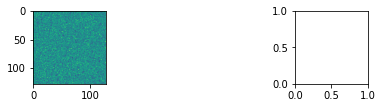

In [12]:
reconst = torch.randn(4, 1, 128, 128)
data = torch.randn(4, 3, 128, 128)

kwargs =  {'nrow':4, "padding":2, "pad_value":1}
images_show = 8
op = reconst[:images_show,:].cpu()
# torchvision.utils.save_image(op,f'{ep}_re.png', **kwargs)
tar = data[:images_show,:].cpu()
# torchvision.utils.save_image(tar, f'{ep}_in.png',**kwargs)
print(op.shape,tar.shape)

n_samp = op.shape[0]
for i in range(1,n_samp+1):
    print((2,n_samp,i), (2,n_samp,i+n_samp-1))

    plt.subplot(2,n_samp,i)
    plt.imshow(op[i,:].squeeze())

    plt.subplot(2,n_samp,i+n_samp-1)
    plt.imshow(tar[i,:].squeeze())

pls.show()
# cat = torch.cat((op,tar),dim=0)
# a = torchvision.utils.save_image(tar, '/content/1.png',**kwargs)
# print('image saved')

1.0 0.0


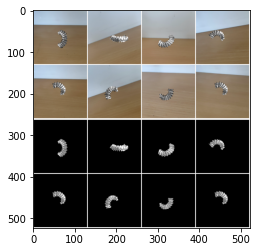

In [31]:
iterator = iter(train_loader)
sample = iterator.next()

augmented,original, dof_vec = sample['augmented'],sample['original'], sample['dof_vec']


def imshow_saver(data, reconst, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    img = torchvision.utils.make_grid(data[:images_show,:], **kwargs)
    npimg = img.numpy()
    data_np = np.transpose(npimg, (1, 2, 0))

    img = torchvision.utils.make_grid(reconst[:images_show,:], **kwargs)
    npimg = img.numpy()
    reconst_np = np.transpose(npimg, (1, 2, 0))

    cat = np.vstack((data_np,reconst_np))

    plt.imshow(cat)
    plt.imsave('1.png', cat)
    print(np.max(reconst_np), np.min(reconst_np))
    plt.show()

imshow_saver(augmented, original)